In [1]:
import pandas as pd
import seaborn as sns
import re

In [2]:

# Define the file path
scan_outside_1 = 'analysis/outside_recording/BaProj1_outside_scan_dump'
scan_outside_2 = 'analysis/outside_recording/BaProj2_outside_scan_dump'
scan_inside_1 = 'analysis/outside_recording/BaProj1_inside_scan_dump'
scan_inside_2 = 'analysis/outside_recording/BaProj1_inside_scan_dump'


In [ ]:
def read_scan_dump(file_path):
    # Define regex patterns to extract the required information
    patterns = {
    'mac_address': re.compile(r'([0-9a-f]{2}:[0-9a-f]{2}:[0-9a-f]{2}:[0-9a-f]{2}:[0-9a-f]{2}:[0-9a-f]{2})'),
    'freq': re.compile(r'freq:\s+(\d+)'),
    'beacon_interval': re.compile(r'beacon interval:\s+(\d+)'),
    'signal': re.compile(r'signal:\s+(-?\d+\.\d+) dBm'),
    'last_seen': re.compile(r'last seen:\s+(\d+) ms ago'),
    'SSID': re.compile(r'SSID:\s+(.+)'),
    'DS_Parameter_set': re.compile(r'DS Parameter set:\s+channel (\d+)'),
    'HT_operation': re.compile(r'HT operation:\n((?:\s+\* .+\n)+)')
    }
    # Initialize lists to store the extracted data
    data = []


    # Read the file and extract the data
    with open(file_path, 'r') as file:
        content = file.read()
        bss_blocks = re.split(r'^BSS ', content, flags=re.MULTILINE)[1:] # first split element is empty


        for block in bss_blocks:
            bss_data = {}
            for key, pattern in patterns.items():
                match = pattern.search(block)
                if match:
                    if key == 'HT_operation':
                        ht_operation_data = match.group(1).strip().split('\n')
                        for item in ht_operation_data:
                            k, v = item.strip().split(': ', 1)
                            k = k.lstrip('* ')
                            bss_data[k.strip()] = v.strip()
                    else:
                        bss_data[key] = match.group(1).strip()
            data.append(bss_data)

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data)

    df = df.apply(pd.to_numeric, errors='ignore')
    return df

In [23]:
df

,mac_address,freq,beacon_interval,signal,last_seen,SSID,DS_Parameter_set,primary channel,secondary channel offset,STA channel width,RIFS,HT protection,non-GF present,OBSS non-GF present,dual beacon,dual CTS protection,STBC beacon,L-SIG TXOP Prot,PCO active,PCO phase
0,30:e2:83:b2:55:d5,2412,100,-82.0,580,MokuGo-004893,1,1.0,no secondary,20 MHz,0.0,nonmember,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,e0:91:f5:ca:3a:36,2437,100,-77.0,11220,AirportLTR,6,6.0,above,any,1.0,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ec:e1:a9:6b:f3:60,2437,102,-70.0,308,Welcome,6,6.0,no secondary,20 MHz,0.0,nonmember,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ec:e1:a9:6b:f3:63,2437,102,-70.0,308,HCI's Network,6,6.0,no secondary,20 MHz,0.0,nonmember,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00:1e:2a:5a:d6:5c,2462,100,-61.0,36,beehive,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,38:90:a5:d4:5a:40,2437,102,-69.0,11552,Welcome,6,6.0,no secondary,20 MHz,1.0,no,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3a:d5:7a:59:b1:bb,2437,100,-60.0,332,DIRECT-bb-HP M283 LaserJet,6,6.0,no secondary,20 MHz,1.0,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,f8:4f:57:a0:70:23,2462,102,-58.0,11260,conference,11,11.0,no secondary,20 MHz,1.0,no,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,f8:4f:57:a0:70:22,2462,102,-58.0,36,HCI's Network,11,11.0,no secondary,20 MHz,1.0,no,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,b8:11:4b:b9:41:a1,2462,100,-74.0,11240,eduroam,11,11.0,no secondary,20 MHz,1.0,nonmember,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


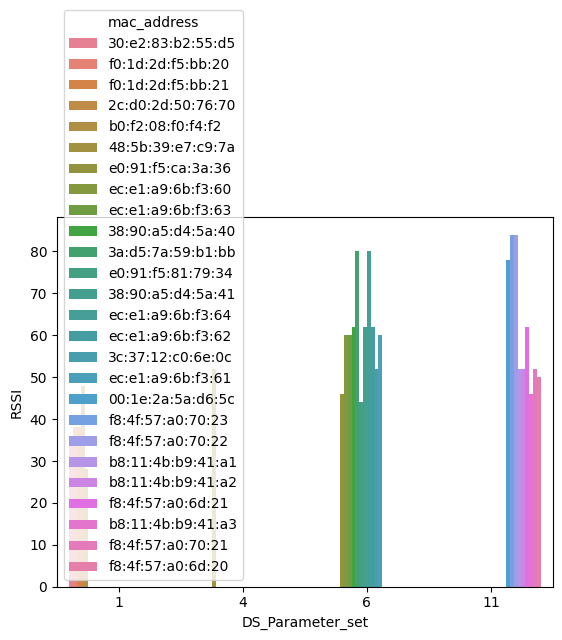

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot = sns.barplot(data=df, x='DS_Parameter_set', y='signal', hue='mac_address')
# Convert signal data from dBm to RSSI
df['RSSI'] = df['signal'].apply(lambda x: 2 * (x + 100))  # Example conversion formula
plot = sns.barplot(data=df, x='DS_Parameter_set', y='RSSI', hue='mac_address')
# plot.set_xlim(0, 14)
# plt.gca().invert_yaxis()
# plt.show()